In [3]:
from statsforecast import StatsForecast
from statsforecast.models import (AutoARIMA, AutoCES, AutoETS, AutoTheta)
from datasetsforecast.losses import mse, mae, smape
from data_loading_finance.loading_data import LoadingData
from ts_tools.tools import tools
import yfinance as yf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from typing import List, Callable
from distributed import Client
from fugue import transform
from fugue_dask import DaskExecutionEngine

import warnings
warnings.filterwarnings("ignore")

In [4]:
# Descargar datos
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'META', 'IBM', 'BTC-USD']
Y_df = yf.download(tickers, start='2019-01-01', end='2023-12-31', interval='1mo')['Adj Close']

# Resetear el índice y transformar el DataFrame
Y_df = Y_df.reset_index().melt(id_vars='Date', var_name='unique_id', value_name='y')
Y_df = Y_df.rename(columns={'Date': 'ds'})

# Calcular los retornos
Y_df['y'] = np.log(Y_df['y'].div(Y_df.groupby('unique_id')['y'].shift(1)))
Y_df = Y_df.dropna(subset=['y']).reset_index(drop=True)
Y_df

[*********************100%%**********************]  8 of 8 completed


,ds,unique_id,y
0,2019-02-01,AAPL,0.039523
1,2019-03-01,AAPL,0.096882
2,2019-04-01,AAPL,0.054901
3,2019-05-01,AAPL,-0.136476
4,2019-06-01,AAPL,0.126520
...,...,...,...
467,2023-08-01,NVDA,0.054674
468,2023-09-01,NVDA,-0.126301
469,2023-10-01,NVDA,-0.064464
470,2023-11-01,NVDA,0.137050


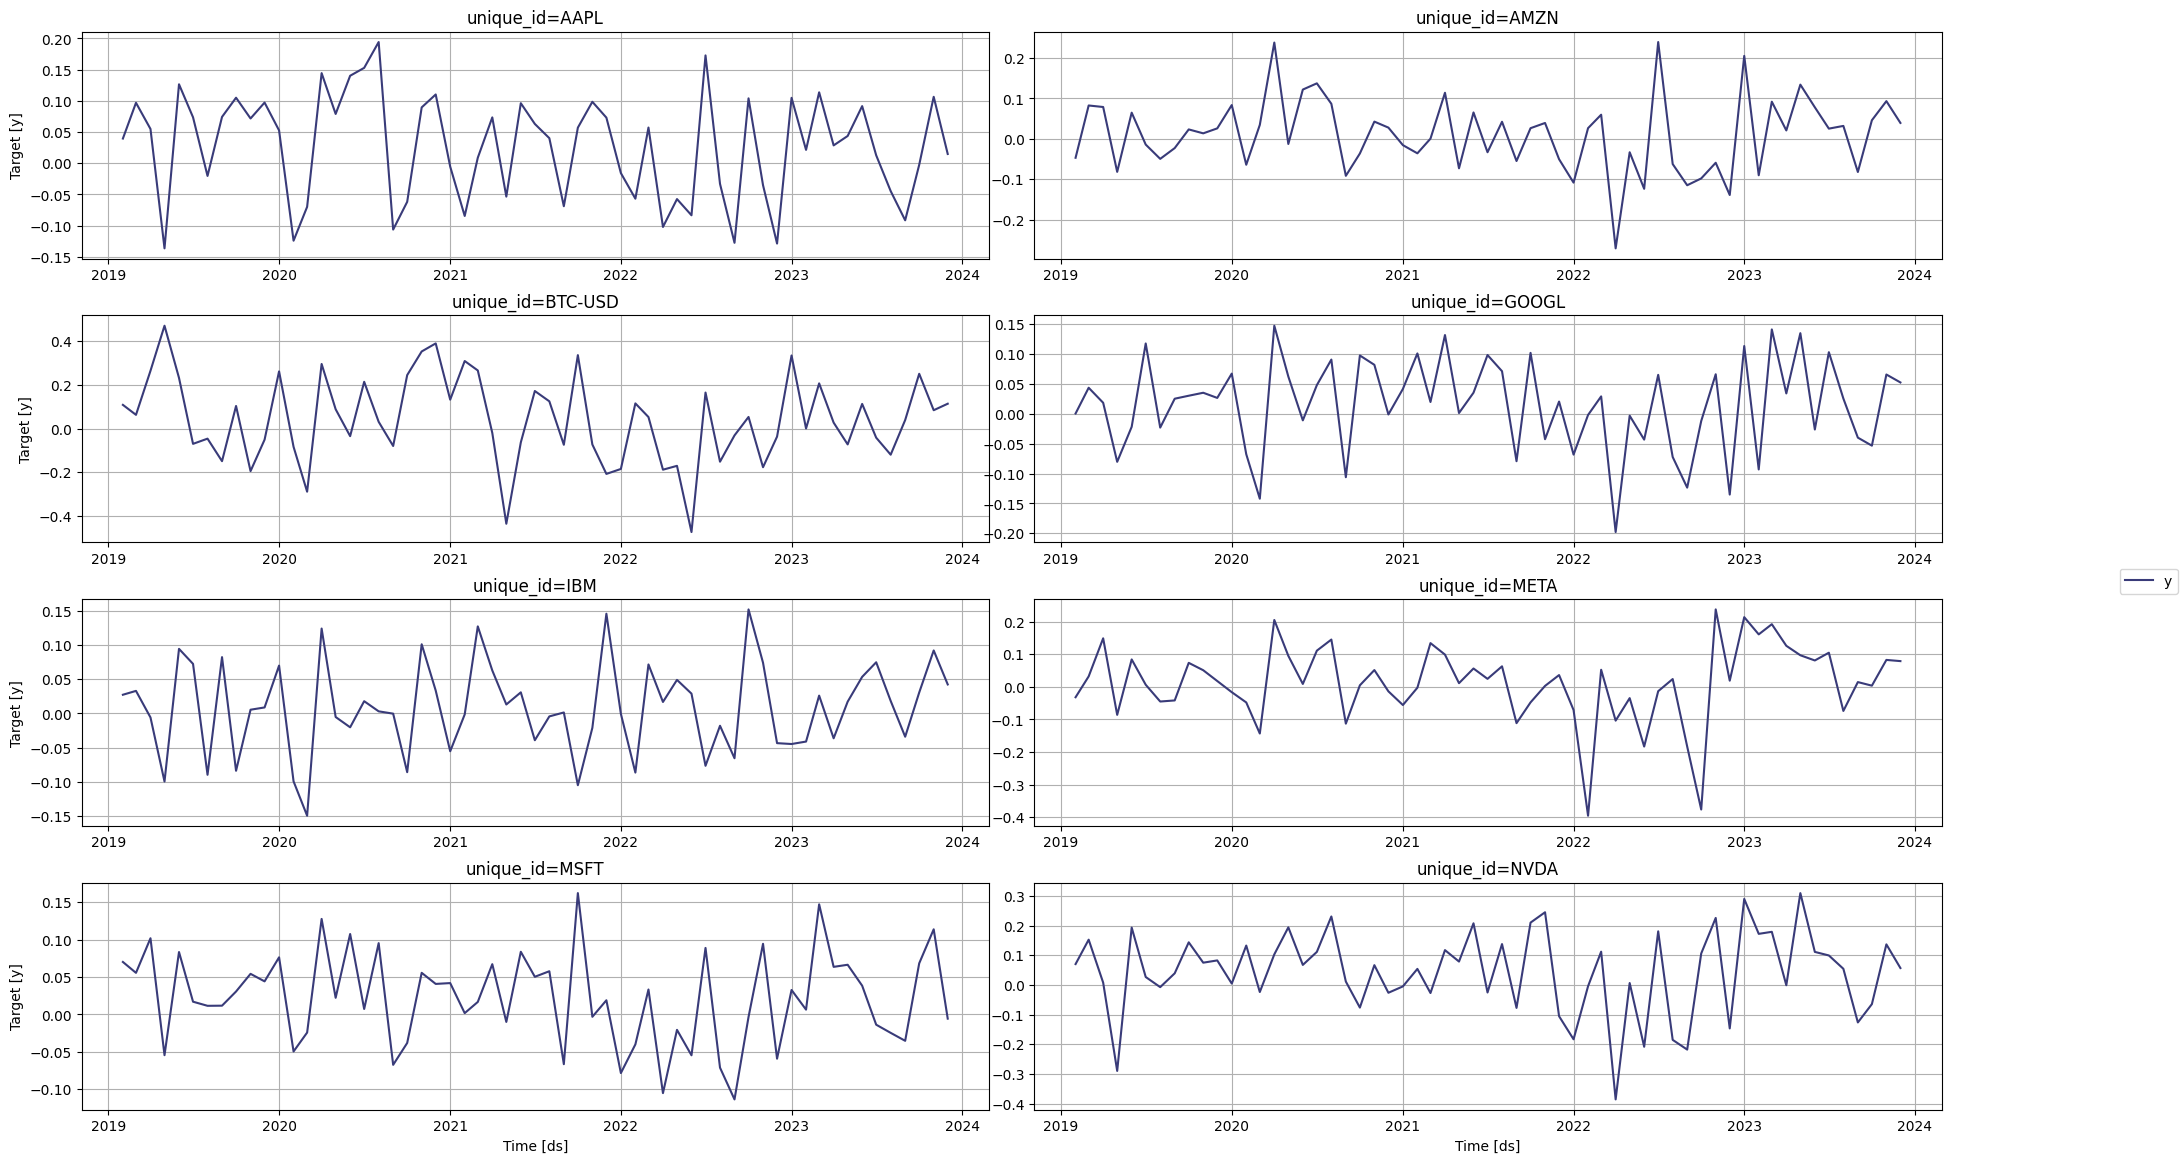

In [5]:
StatsForecast.plot(Y_df)

In [6]:
season_length=12
horizon = 3

models = [
    AutoARIMA(season_length=season_length),
    AutoCES(season_length=season_length), 
    AutoETS(season_length=season_length),
    AutoTheta(season_length=season_length),
]

# Instantiate StatsForecast class with models, data frequency ('MS' for monthly),
# and parallel computation on all CPU cores (n_jobs=-1)
sf = StatsForecast(
    models=models, # models for forecasting
    freq='MS',  # frequency of the data
    n_jobs=1  # number of jobs to run in parallel, -1 means using all processors
)

In [7]:
# Generate forecasts for the specified horizon using the sf object
Y_hat_df = sf.forecast(df=Y_df, h=horizon) # forecast data
Y_hat_df.head() 

,ds,AutoARIMA,CES,AutoETS,AutoTheta
unique_id,,,,,
AAPL,2024-01-01,0.021517,0.013759,0.026714,0.011821
AAPL,2024-02-01,0.004391,-0.074926,0.026714,0.011401
AAPL,2024-03-01,0.023327,0.012974,0.026714,0.010980
AMZN,2024-01-01,0.000000,0.047008,0.009602,0.018290
AMZN,2024-02-01,0.000000,-0.035163,0.009602,0.018145


In [8]:
cv_df = sf.cross_validation(df=Y_df, h=horizon, n_windows=5, step_size=horizon, level=[90])
cv_df.head()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,CES,CES-lo-90,CES-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,AutoTheta,AutoTheta-lo-90,AutoTheta-hi-90
unique_id,,,,,,,,,,,,,,,
AAPL,2022-10-01,2022-09-01,0.103956,0.017409,-0.129307,0.164126,-0.003503,-0.182128,0.170875,0.027934,-0.124880,0.180748,-0.010722,-0.150559,0.165657
AAPL,2022-11-01,2022-09-01,-0.035243,0.030072,-0.116644,0.176788,0.052831,-0.119972,0.227978,0.027934,-0.124880,0.180748,-0.011590,-0.173180,0.121948
AAPL,2022-12-01,2022-09-01,-0.128762,0.022315,-0.124402,0.169031,0.060638,-0.113259,0.235133,0.027934,-0.124880,0.180748,-0.012457,-0.204738,0.137634
AAPL,2023-01-01,2022-12-01,0.104829,-0.004202,-0.153417,0.145014,-0.042080,-0.222908,0.147549,0.024894,-0.129563,0.179352,-0.018198,-0.158592,0.158884
AAPL,2023-02-01,2022-12-01,0.021393,-0.015085,-0.164301,0.134130,-0.119093,-0.300877,0.064557,0.024894,-0.129563,0.179352,-0.019107,-0.181270,0.114825


In [9]:
cv_df.tail()

,ds,cutoff,y,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,CES,CES-lo-90,CES-hi-90,AutoETS,AutoETS-lo-90,AutoETS-hi-90,AutoTheta,AutoTheta-lo-90,AutoTheta-hi-90
unique_id,,,,,,,,,,,,,,,
NVDA,2023-08-01,2023-06-01,0.054674,0.0,-0.250984,0.250984,0.084834,-0.227520,0.409733,0.046824,-0.201709,0.295358,0.073550,-0.192209,0.291847
NVDA,2023-09-01,2023-06-01,-0.126301,0.0,-0.250984,0.250984,-0.032978,-0.343174,0.288946,0.046824,-0.201709,0.295358,0.073550,-0.244625,0.317039
NVDA,2023-10-01,2023-09-01,-0.064464,0.0,-0.247008,0.247008,0.132452,-0.177083,0.442879,0.044730,-0.200015,0.289474,0.053979,-0.174034,0.341577
NVDA,2023-11-01,2023-09-01,0.137050,0.0,-0.247008,0.247008,0.197751,-0.113806,0.515195,0.044730,-0.200015,0.289474,0.053979,-0.208665,0.269716
NVDA,2023-12-01,2023-09-01,0.057175,0.0,-0.247008,0.247008,-0.068979,-0.386505,0.244419,0.044730,-0.200015,0.289474,0.053979,-0.260466,0.294613


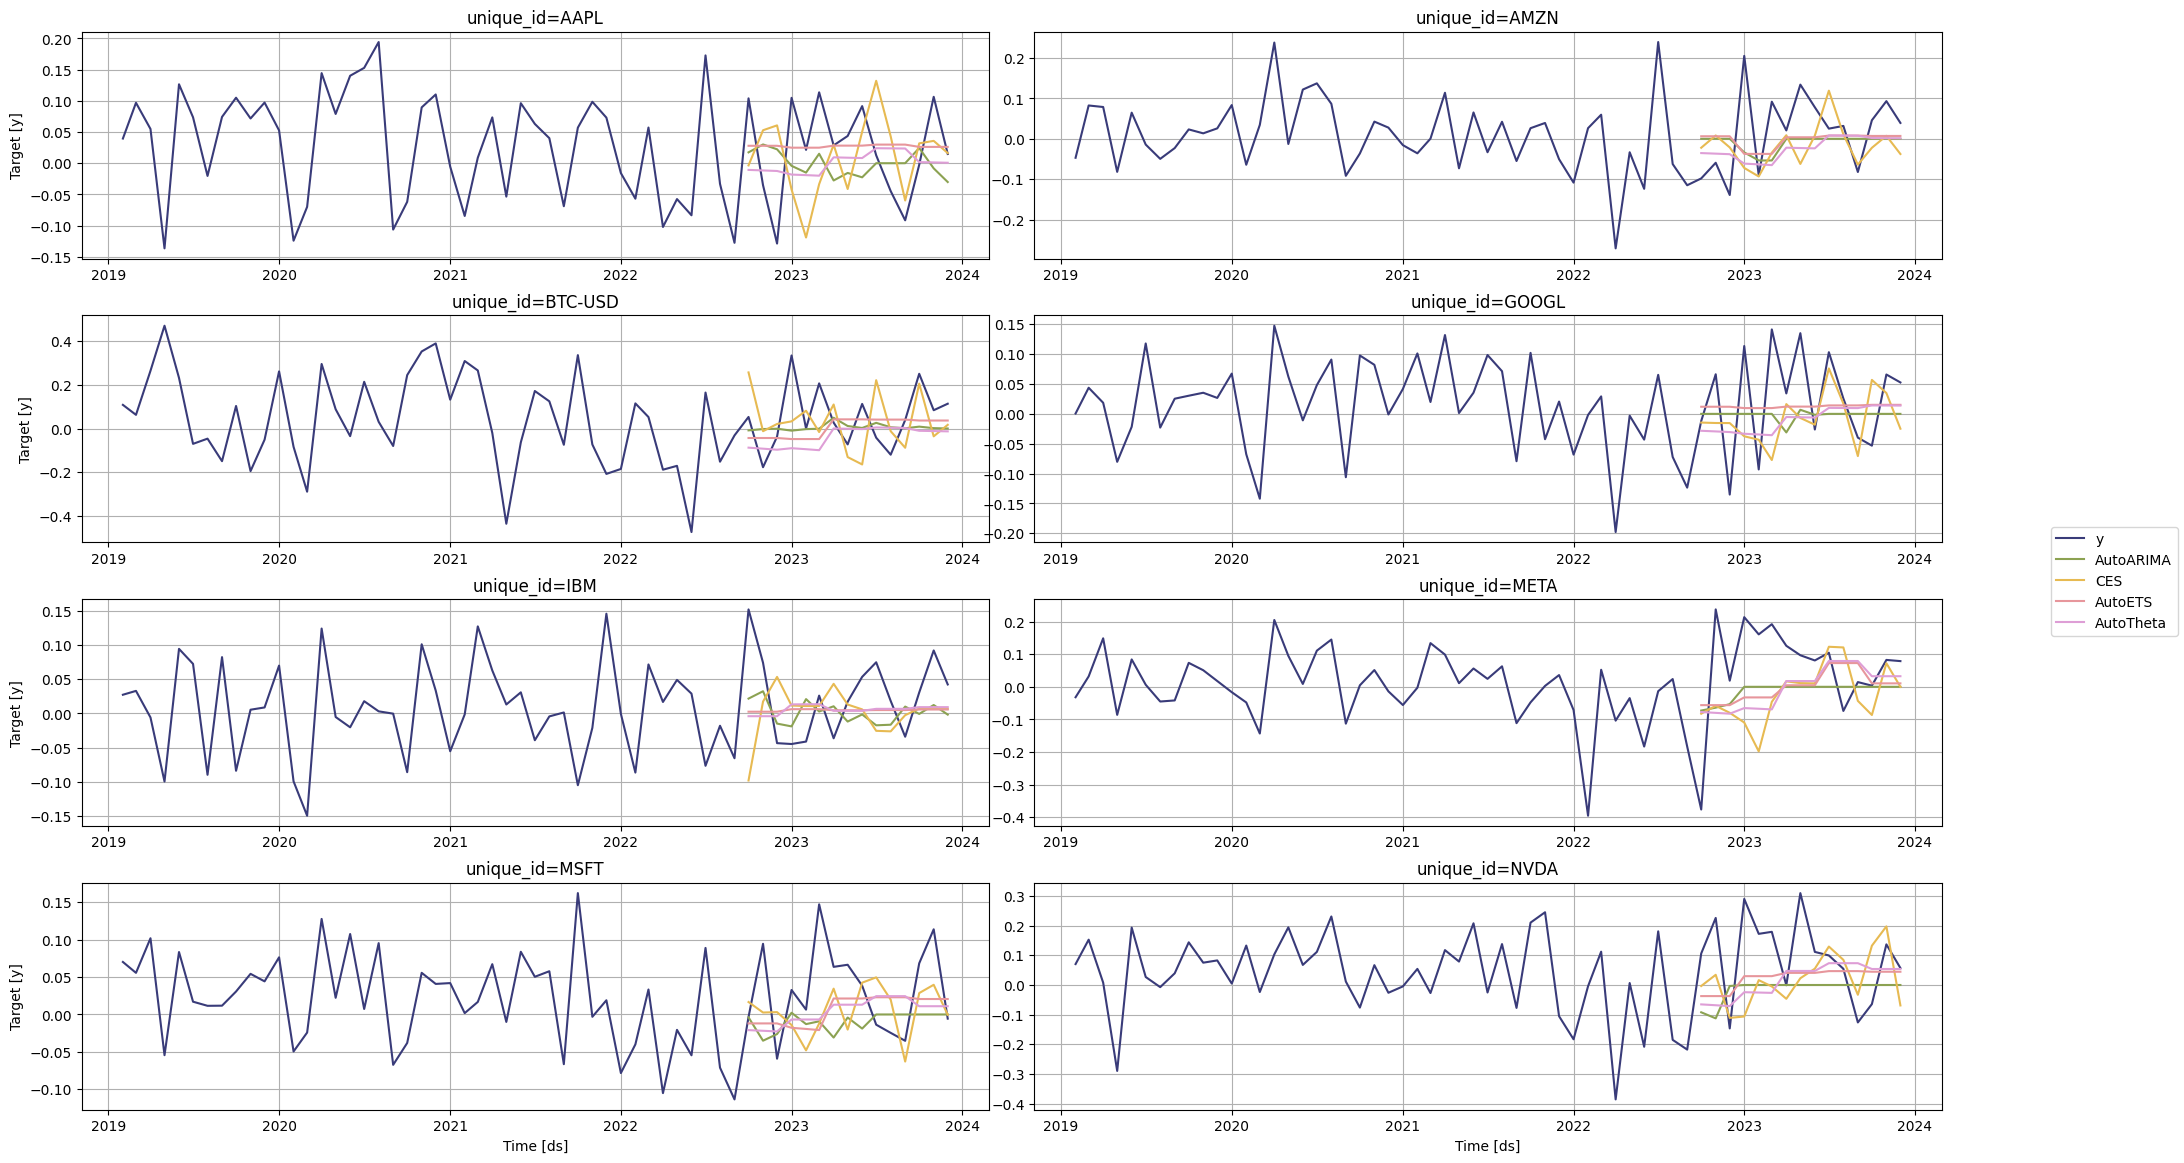

In [10]:
StatsForecast.plot(Y_df, cv_df.drop(['cutoff', 'y'], axis=1))

In [11]:
cv_df = pd.DataFrame(cv_df)
cv_df.index.name = 'unique_id'

# Transformar índice en columna
cv_df.reset_index(inplace=True)

In [12]:
def evaluate(df: pd.DataFrame, metrics: List[Callable]) -> pd.DataFrame:
    eval_ = {}
    models = df.loc[:, ~df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
    for model in models:
        eval_[model] = {}
        for metric in metrics:
            eval_[model][metric.__name__] = metric(df['y'], df[model])
    eval_df = pd.DataFrame(eval_).rename_axis('metric').reset_index()
    eval_df.insert(0, 'cutoff', df['cutoff'].iloc[0])
    eval_df.insert(0, 'unique_id', df['unique_id'].iloc[0])
    return eval_df

In [13]:
str_models = cv_df.loc[:, ~cv_df.columns.str.contains('unique_id|y|ds|cutoff|lo|hi')].columns
str_models = ','.join([f"{model}:float" for model in str_models])
cv_df['cutoff'] = cv_df['cutoff'].astype(str)
cv_df['unique_id'] = cv_df['unique_id'].astype(str)

In [14]:
client = Client() # without this, dask is not in distributed mode
# fugue.dask.dataframe.default.partitions determines the default partitions for a new DaskDataFrame
engine = DaskExecutionEngine({"fugue.dask.dataframe.default.partitions": 96})

In [15]:
evaluation_df = transform(
    cv_df.loc[:, ~cv_df.columns.str.contains('lo|hi')], 
    evaluate, 
    engine="dask",
    params={'metrics': [mse, mae, smape]}, 
    schema=f"unique_id:str,cutoff:str,metric:str, {str_models}", 
    as_local=True,
    partition={'by': ['unique_id', 'cutoff']}
)
evaluation_df.head()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask

2024-07-10 10:18:47,673 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9c8e8519403e126f239494e8eaf410fa initialized by task ('shuffle-transfer-9c8e8519403e126f239494e8eaf410fa', 2) executed on worker tcp://127.0.0.1:50385
2024-07-10 10:18:50,094 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9c8e8519403e126f239494e8eaf410fa deactivated due to stimulus 'task-finished-1720599529.959511'


,unique_id,cutoff,metric,AutoARIMA,CES,AutoETS,AutoTheta
0,AAPL,2022-12-01,mse,0.007639,0.020999,0.00476,0.011547
1,AAPL,2022-12-01,mae,0.08133,0.144877,0.057396,0.099063
2,AAPL,2022-12-01,smape,184.302673,200.0,88.830963,200.0
3,AAPL,2023-06-01,mse,0.00351,0.007652,0.006854,0.00602
4,AAPL,2023-06-01,mae,0.049624,0.079612,0.07098,0.06496


In [16]:
# Calculate the mean metric for each cross validation window
evaluation_df.groupby(['cutoff', 'metric']).mean(numeric_only=True)

AutoARIMA         CES     AutoETS   AutoTheta
cutoff     metric                                                
2022-09-01 mae         0.1169    0.119965    0.112788    0.110224
           mse       0.021889    0.020568    0.019261    0.019244
           smape   169.842728  165.571381  170.209198  145.075607
2022-12-01 mae       0.128908    0.162817    0.133368    0.157258
           mse        0.02464    0.038264    0.026716    0.036723
           smape   184.164169  178.602188  169.261887  182.928467
2023-03-01 mae       0.082338     0.07904     0.06508    0.071266
           mse       0.010365    0.012048    0.007454    0.008078
           smape   191.955963   122.72757  132.921082  159.283569
2023-06-01 mae       0.058593    0.069699    0.061657    0.060265
           mse       0.004702    0.008477    0.006068    0.005846
           smape   199.419586  124.171417  144.490234  149.802338
2023-09-01 mae       0.072533    0.068479    0.060356    0.065945
           mse       0.007611    0.006578    0.005483    0.007258
           smape   197.009598  139.836594  135.186722  155.048676

In [17]:
evaluation_df_melted = pd.melt(evaluation_df, id_vars=['unique_id', 'cutoff', 'metric'], var_name='model', value_name='error')

<Axes: xlabel='error', ylabel='model'>

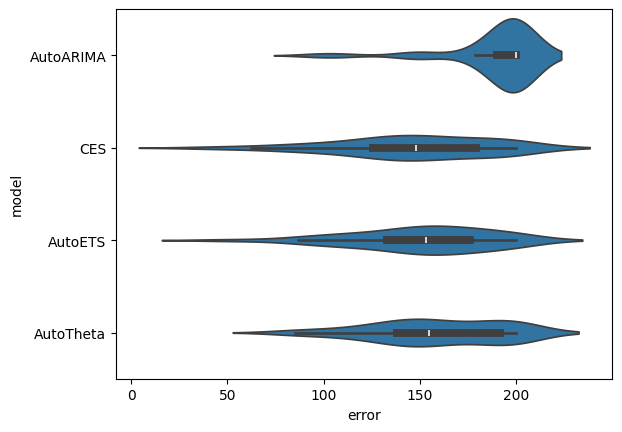

In [18]:
sns.violinplot(evaluation_df_melted.query('metric=="smape"'), x='error', y='model')

<Axes: xlabel='n', ylabel='best_model'>

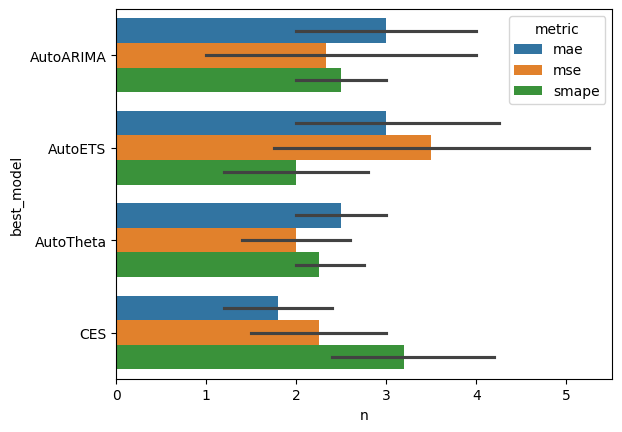

In [19]:
# Choose the best model for each time series, metric, and cross validation window
evaluation_df['best_model'] = evaluation_df.idxmin(axis=1, numeric_only=True)
# count how many times a model wins per metric and cross validation window
count_best_model = evaluation_df.groupby(['cutoff', 'metric', 'best_model']).size().rename('n').to_frame().reset_index()
# plot results
sns.barplot(count_best_model, x='n', y='best_model', hue='metric')